In [2]:
%matplotlib inline

import time

# math and data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow import keras

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [3]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

## Training

In [4]:
load_data.describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


In [5]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24

### Release architect 001

In [6]:
batch_input_shape = (n_batch, 1, n_input)
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True,
                'activation': 'relu',
                'return_sequences': True
            }
        },
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': 100,
                'activation': 'relu',
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [7]:
model = GeneralModel(config)

In [ ]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

total_start_time = time.time()

epoch_timers = []

for i in range(num_passes_through_data):
    epoch_start_time = time.time()
    model.fit(consumption_train)
    epoch_timers.append((epoch_start_time, time.time()))
    
total_end_time = time.time()

Fitting the data:   4%|▍         | 32/758 [01:25<31:38,  2.62s/it]

In [9]:
total_end_time - total_start_time

5967.126497030258

In [10]:
epoch_timers

[(1539969937.8258982, 1539971924.9270794),
 (1539971924.9270804, 1539973915.033192),
 (1539973915.0331929, 1539975904.9522426)]

## Make predict

In [ ]:
my_submission = model.make_submission(submission_format, cold_start_test)

Forecasting from Cold Start Data:   2%|▏         | 12/625 [00:12<09:41,  1.05it/s]

In [15]:
my_submission.head()

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,NaN,daily
1,102781,2013-03-04,20.034375,NaN,daily
2,102781,2013-03-05,19.189583,NaN,daily
3,102781,2013-03-06,18.397917,NaN,daily
4,102781,2013-03-07,20.762500,NaN,daily


In [12]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: consumption, dtype: float64

In [13]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: consumption, dtype: float64

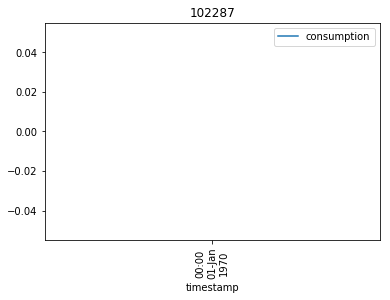

In [14]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [15]:
my_submission.head(20)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,3.729989e+05,daily
1,102781,2013-03-04,20.034375,3.729989e+05,daily
2,102781,2013-03-05,19.189583,3.729989e+05,daily
3,102781,2013-03-06,18.397917,3.729989e+05,daily
4,102781,2013-03-07,20.762500,3.729989e+05,daily
5,102781,2013-03-08,19.800000,3.729989e+05,daily
6,102781,2013-03-09,20.466667,3.729989e+05,daily
7,103342,2013-06-26,10.486607,1.204608e+07,weekly
8,103342,2013-07-03,10.006548,1.256478e+07,weekly


In [16]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)
my_submission.to_csv(save_path / "release-001-20181019.csv", index_label='pred_id')

Submitted on 2018-10-19: 0.4970

In [24]:
model_path = Path('..', '..', 'data', 'model')
model_path.mkdir(exist_ok=True, parents=True)
keras.models.save_model(
    model.model,
    model_path / 'release-01-20181019.hdf5'
)